# Лабораторная работа №2. Задача классификации

**Тема:** *Анализ и сравнение разных классификаторов*

**Цели:**

- *Научиться обрабатывать датасет*
- *Реализовать разные классификаторы*
- *Понять, как интерпретировать важность признаков (feature importance)*
- *Понять, как увеличивать кол-во признаков (feature tuning)*


**Модели:**

- *Линейная регрессия*
- *Метод опорных векторов (SVM)*
- *$K$ - ближайших соседей*
- *Дерево решений*
- *Случайный лес*
- *Градиентный бустинг*


#### 👋🏻 ЧТО НУЖНО СДЕЛАТЬ СТУДЕНТАМ ???

1. Загрузить датасет, который был в `lr_1.ipynb`
2. Свести его к задаче классификации (бинарной или многоклассовой).
3. Обработать датасет
4. Обучить модели
5. (команда) Реализовать свою логистическую регрессию. Настроить параметр вероятности ответа как if $ y_{pred} < 0,5$ then $0$ else $1$ чтобы получилась бинарная классификация
6. **(необезательно, но можно получить плюсик от меня)** С помощью `optuna` реализовать подгонку гиперпараметров для `CatBoost`.
7. Ответить на вопросы
8. Придумать какую-то уникальность работы, то, что будет вас отличать от других, и это вам надо будет мне "продать".
8. Составить `презентацию` о проделанной работе (10-15 слайдов), а именно: нужно выбрать одну модель, и для нее описать подготовку датасета, распределение данных, показать какие метрики выдает модель при разных настройках, побольше описательных графиков. Вам нужно будет мне "продавть ваше решение".
9. Записать `видео вашей защиты на 5 минут`, где вы рассказываете только о вашей фиче.

#### Форматы сдачи

1. Один студент, делает только стандартные реализации. Упрощенная форма сдачи.
2. Команда из 2х людей. Нужно обязательно сделать Логистическую регрессию и сравнить ее с лучшей стандартной моделью.
3. Команда из 3х людей. Сделать то, что и в команде из 2х человек + обязательно реализация подбора гиперпараметров, с помощью Optuna.

#### Как получить дополнительные плюсики

Я буду оценивать вашу работу комплексно, т.к. нас `55 человек`, то:
1. Самую лучшую работу, сданную на 5, буду расценивать за 6 плюсиков. Если вы в соло делаете, это большое преимущество, 6 баллов ваши, если командой, то делится на команду.
2. 5 человек получат по 2 плюсика
3. 10 человек получат по 1 плюсику

#### Дедлайны

- До 24.10.25 argmax(оценки) = 5 (есть возможность на +)
- До 31.10.25 argmax(оценки) = 4 (нет возможности на +)
- До 07.11.25 argmax(оценки) = 3 (нет возможности на +)

## 1. Введение

Цель: загрузить датасет, сделать описание и сформулировать задачу

### 1.0. Испортируем библиотеки и зафиксируем случайность

In [ ]:
# Main libs for data
from google.colab import drive
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import StandardScaler

In [ ]:
# Project Settings
RANDOM_STATE = 42

In [ ]:
!pip install ucimlrepo
!pip install catboost
!pip install xgboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 7.6 MB/s eta 0:00:00


### 1.1. Загрузка датасета

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
abalone = fetch_ucirepo(id=1)

# data (as pandas dataframes)
X = abalone.data.features
y = abalone.data.targets

# metadata
print(abalone.metadata)

# variable information
print(abalone.variables)

{'uci_id': 1, 'name': 'Abalone', 'repository_url': 'https://archive.ics.uci.edu/dataset/1/abalone', 'data_url': 'https://archive.ics.uci.edu/static/public/1/data.csv', 'abstract': 'Predict the age of abalone from physical measurements', 'area': 'Biology', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular'], 'num_instances': 4177, 'num_features': 8, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': [], 'target_col': ['Rings'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C55C7W', 'creators': ['Warwick Nash', 'Tracy Sellers', 'Simon Talbot', 'Andrew Cawthorn', 'Wes Ford'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting the age of abalone from physical measurements.  The age of abalone is determined by cutting the shell through the cone, staining it, and counting the number of rings through a microscope -- 

In [ ]:
# Convert target to DataFrame
y_df = pd.DataFrame(y)

# Combine features and target
df = pd.concat([X, y_df], axis=1)

df.head()

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole_weight    4177 non-null   float64
 5   Shucked_weight  4177 non-null   float64
 6   Viscera_weight  4177 non-null   float64
 7   Shell_weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


### 1.2. Поставновка задачи

**Целевая задача:** классическая задача классификации качества вина. Мы можем решить её как:
- **Мультиклассовая классификация** (каждое качество — отдельный класс [3...8])
- **Бинарная классификация** (например, low-quality vs high-quality, порог качества >= 6 как "хорошее").


## 2. Подготовка данных

### 2.0. Предварительный анализ данных

Типы признаков

In [ ]:
print(f'Типы признаков:\n{df.dtypes}')

Типы признаков:
Sex                object
Length            float64
Diameter          float64
Height            float64
Whole_weight      float64
Shucked_weight    float64
Viscera_weight    float64
Shell_weight      float64
Rings               int64
dtype: object


В датасете все признаки имеют тип `float64`, только целевая переменная имеет тип `int64`.

In [ ]:
print(f'Пропуски данных:\n{df.isna().sum()}')

Пропуски данных:
Sex               0
Length            0
Diameter          0
Height            0
Whole_weight      0
Shucked_weight    0
Viscera_weight    0
Shell_weight      0
Rings             0
dtype: int64


В датасете нет пропусков, от них не избавляемся

In [ ]:
print('Базовая статистика в удобном виде:')
df.describe().T

Базовая статистика в удобном виде:


,count,mean,std,min,25%,50%,75%,max
Length,4177.0,0.523992,0.120093,0.0750,0.4500,0.5450,0.615,0.8150
Diameter,4177.0,0.407881,0.099240,0.0550,0.3500,0.4250,0.480,0.6500
Height,4177.0,0.139516,0.041827,0.0000,0.1150,0.1400,0.165,1.1300
Whole_weight,4177.0,0.828742,0.490389,0.0020,0.4415,0.7995,1.153,2.8255
Shucked_weight,4177.0,0.359367,0.221963,0.0010,0.1860,0.3360,0.502,1.4880
Viscera_weight,4177.0,0.180594,0.109614,0.0005,0.0935,0.1710,0.253,0.7600
Shell_weight,4177.0,0.238831,0.139203,0.0015,0.1300,0.2340,0.329,1.0050
Rings,4177.0,9.933684,3.224169,1.0000,8.0000,9.0000,11.000,29.0000


По базовой статистике видно, что у некоторых фичей есть скос и выбросы.

### 2.1. Feauture Engineering

In [ ]:
median_h = df.loc[(df["Height"] > 0) & (df["Height"] < 0.3), "Height"].median()
df.loc[(df["Height"] == 0) | (df["Height"] > 0.3), "Height"] = median_h

In [ ]:
df["Height"].describe().T

,Height
count,4177.000000
mean,0.139257
std,0.038359
min,0.010000
25%,0.115000
50%,0.140000
75%,0.165000
max,0.250000


In [ ]:
df = pd.get_dummies(df, columns=["Sex"], drop_first=False)

In [ ]:
df.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,False,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,False,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,True,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,False,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,False,True,False


In [ ]:
L = df["Length"]
D = df["Diameter"]
H = df["Height"]

#df["Vol_ellipsoid"] = (math.pi / 6.0) * L * D * H #объем

#df["Area_proj"] = math.pi * (L / 2.0) * (D / 2.0) #проекция

df["L_over_D"] = L / (D.replace(0, np.nan))
#df["H_over_D"] = H / (D.replace(0, np.nan))

W = df["Whole_weight"]
df["meat_ratio"] = df["Shucked_weight"] / W.replace(0, np.nan)
df["viscera_ratio"] = df["Viscera_weight"] / W.replace(0, np.nan)
df["shell_ratio"] = df["Shell_weight"] / W.replace(0, np.nan)

#df["density_vol"] = df["Whole_weight"] / df["Vol_ellipsoid"].replace(0, np.nan)
#df["meat_per_len"] = df["Shucked_weight"] / L.replace(0, np.nan)
#df["whole_per_len"] = df["Whole_weight"] / L.replace(0, np.nan)

#df["Length_sq"] = L ** 2
#df["Diameter_sq"] = D ** 2
#df["Whole_weight_sq"] = df["Whole_weight"] ** 2

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Length,4177.0,0.523992,0.120093,0.075000,0.450000,0.545000,0.615000,0.815000
Diameter,4177.0,0.407881,0.099240,0.055000,0.350000,0.425000,0.480000,0.650000
Height,4177.0,0.139257,0.038359,0.010000,0.115000,0.140000,0.165000,0.250000
Whole_weight,4177.0,0.828742,0.490389,0.002000,0.441500,0.799500,1.153000,2.825500
Shucked_weight,4177.0,0.359367,0.221963,0.001000,0.186000,0.336000,0.502000,1.488000
Viscera_weight,4177.0,0.180594,0.109614,0.000500,0.093500,0.171000,0.253000,0.760000
Shell_weight,4177.0,0.238831,0.139203,0.001500,0.130000,0.234000,0.329000,1.005000
Rings,4177.0,9.933684,3.224169,1.000000,8.000000,9.000000,11.000000,29.000000
L_over_D,4177.0,1.291880,0.059065,0.493333,1.257732,1.288462,1.321839,2.333333
meat_ratio,4177.0,0.432414,0.105765,0.175258,0.395100,0.430592,0.466175,4.691943


### 2.2. Предобработка данных

#### 2.2.0 Сведение к задачи бинарной классификации

In [ ]:
def make_age_class(rings):
    if rings <= 8:
        return 0
    elif rings <= 10:
        return 1
    else:
        return 2

df["Rings"] = df["Rings"].apply(make_age_class)
df.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M,L_over_D,meat_ratio,viscera_ratio,shell_ratio
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,2,False,False,True,1.246575,0.436770,0.196498,0.291829
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,False,False,True,1.320755,0.441242,0.215078,0.310421
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,1,True,False,False,1.261905,0.378877,0.209010,0.310192
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,1,False,False,True,1.205479,0.417636,0.220930,0.300388
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,0,False,True,False,1.294118,0.436585,0.192683,0.268293


#### 2.3.1. Создадим копию данных `df_lin` для линейной `классификации`, `KNN`, `SVM`, `df_raw` оставим для бустинга и деревьев 😸

In [ ]:
df_lin = df.copy()

#### 2.3.2. Создание методов для отрисовки и обработки данных

Корреляционная матрица

In [ ]:
cols_to_drop = [
    'Height',
    'whole_per_len',
    'Shucked_weight', 'Viscera_weight', 'Shell_weight',
    'Sex_I', 'Sex_M'
]

df_lin = df.drop(columns=[c for c in cols_to_drop if c in df.columns]).copy()

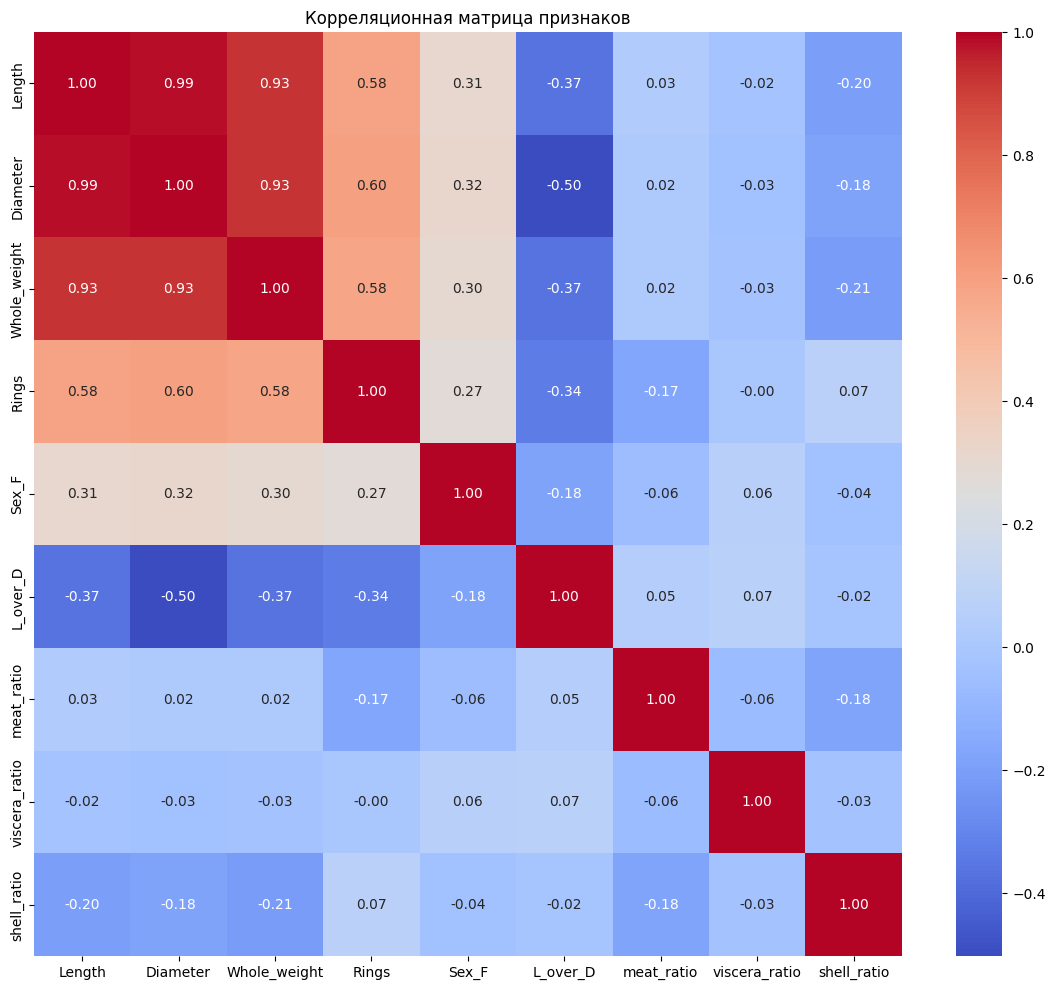

In [ ]:
def draw_corr_matrix(df):
    plt.figure(figsize=(14,12))
    sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Корреляционная матрица признаков")
    plt.show()

# example
draw_corr_matrix(df_lin)

Гистограмма распределения

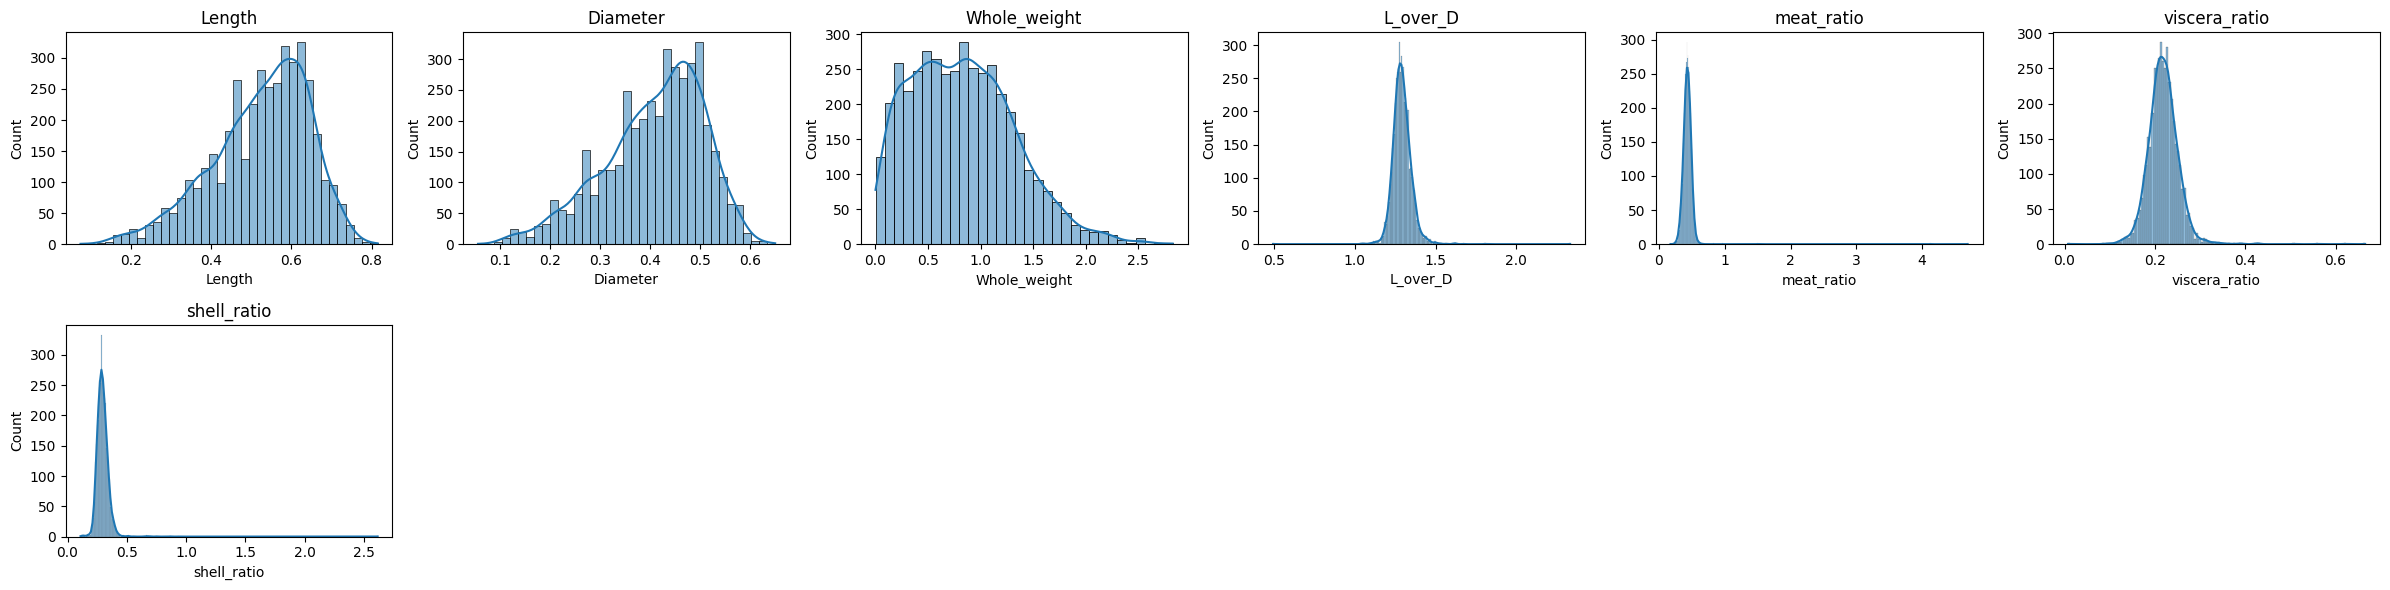

In [ ]:
def draw_hist(df: pd.DataFrame, n_cols=6):
    float_cols = df.select_dtypes(include='float').columns
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()  # делаем одномерным массивом для удобства

    for i, col in enumerate(float_cols):
        sns.histplot(df[col], kde=True, ax=axs[i])
        axs[i].set_title(f'{col}')

    # Если графиков меньше, чем ячеек в сетке, скрываем лишние
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_hist(df_lin)

Соотношение с целевой переменной + коэфициент пирсона

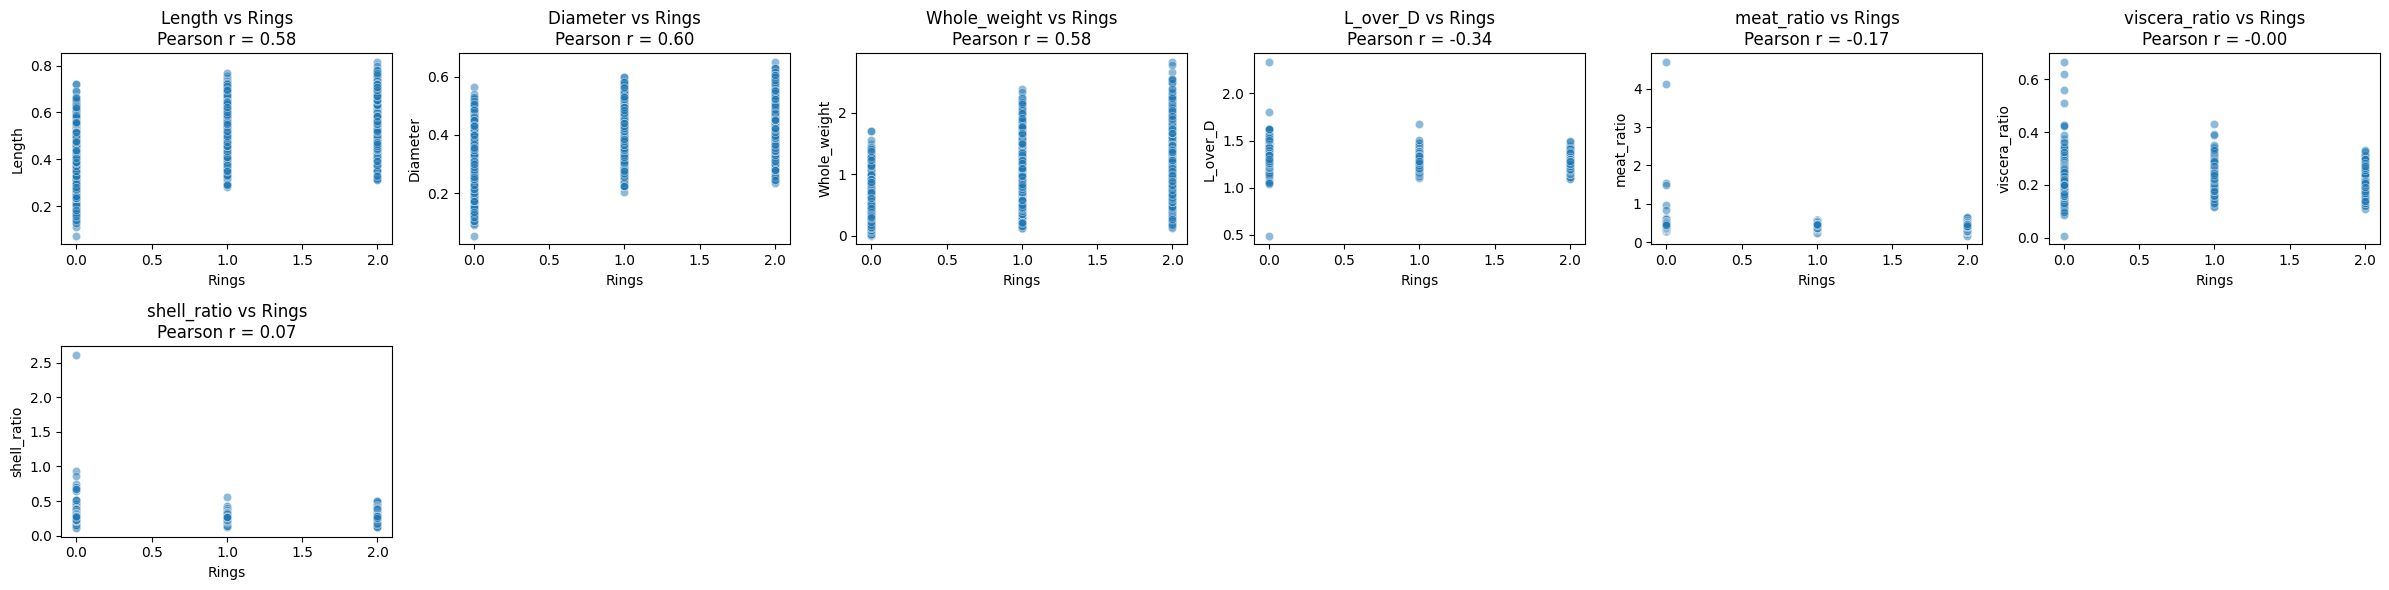

In [ ]:
def draw_scatter_vs_target(df: pd.DataFrame, target: str, n_cols=6):
    float_cols = df.select_dtypes(include=['float', 'int']).columns.drop(target)
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()

    for i, col in enumerate(float_cols):
        sns.scatterplot(x=target, y=col, data=df, ax=axs[i], alpha=0.5)

        # коэффициент корреляции Пирсона
        corr = df[col].corr(df[target], method='pearson')
        axs[i].set_title(f'{col} vs {target}\nPearson r = {corr:.2f}')

    # скрываем лишние пустые ячейки
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_scatter_vs_target(df_lin, target="Rings")

Ящик с усами

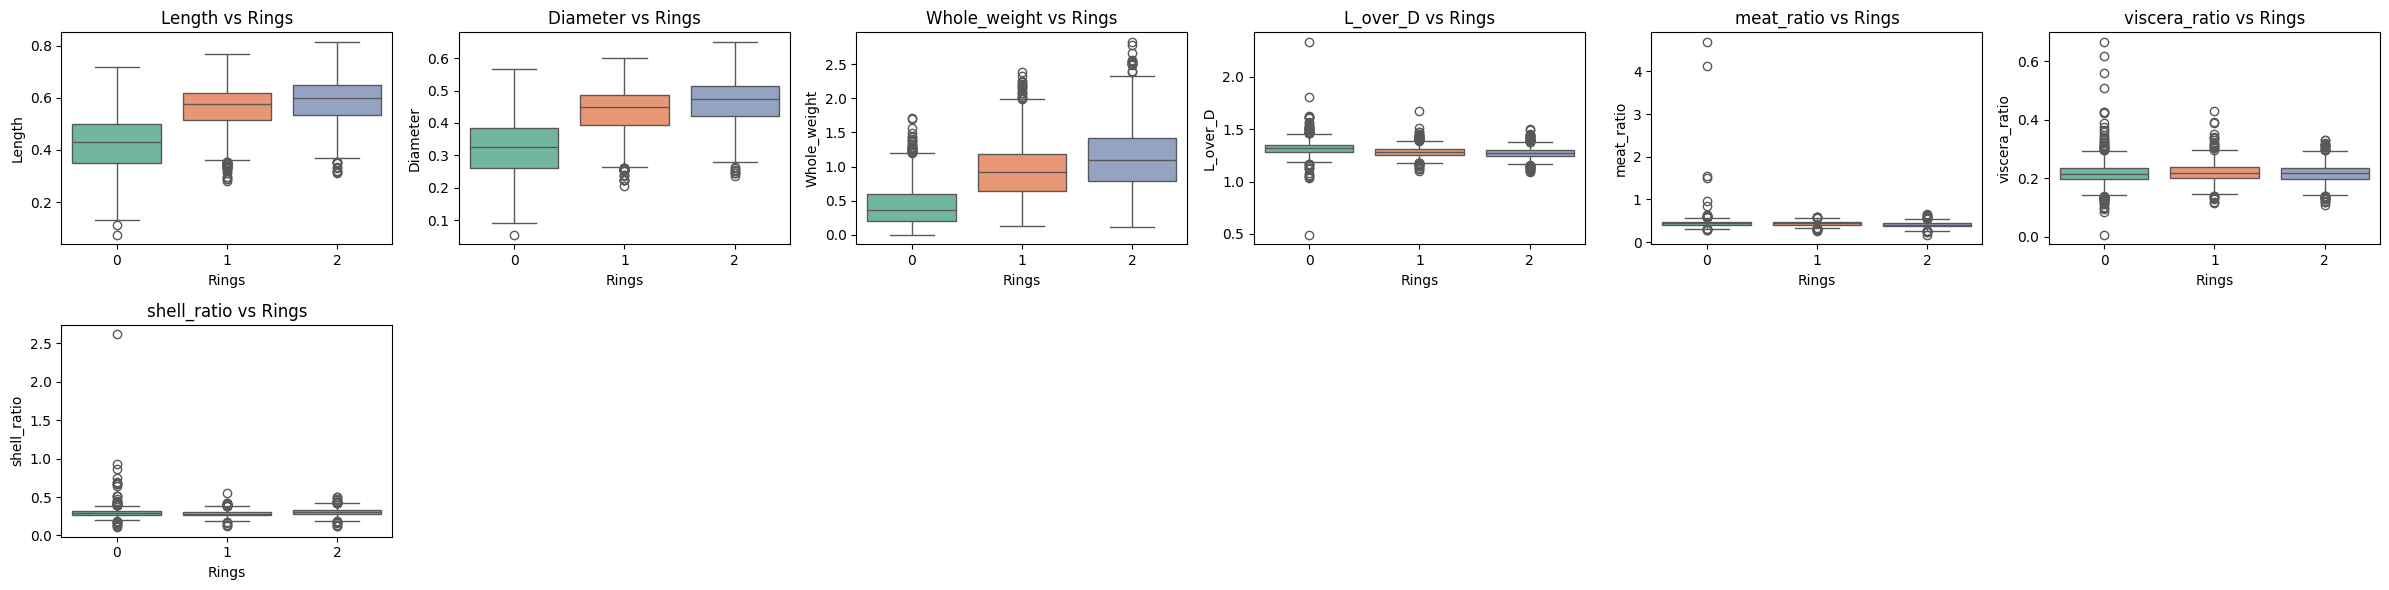

In [ ]:
def draw_boxplots(df: pd.DataFrame, target: str, n_cols=6):
    float_cols = df.select_dtypes(include=['float', 'int']).columns.drop(target)
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()

    for i, col in enumerate(float_cols):
        sns.boxplot(
            x=target, y=col, data=df, ax=axs[i],
            hue=target, palette="Set2", legend=False
        )
        axs[i].set_title(f'{col} vs {target}')

    # скрываем лишние пустые ячейки
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# example
draw_boxplots(df_lin, target="Rings")

Удаление выбросов

In [ ]:
# обработка выбросов
def remove_outliers_iqr(df, columns, low, high):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(low)
        Q3 = df_clean[col].quantile(high)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

Подготовка правых скосов

In [ ]:
# обработка скосов
def prepare_skew(df: pd.DataFrame, columns: list[str]):
    for col in columns:
        df[col] = np.log1p(df[col])
    return df

#### 2.3.3. Посмотрим на выбросы переменных

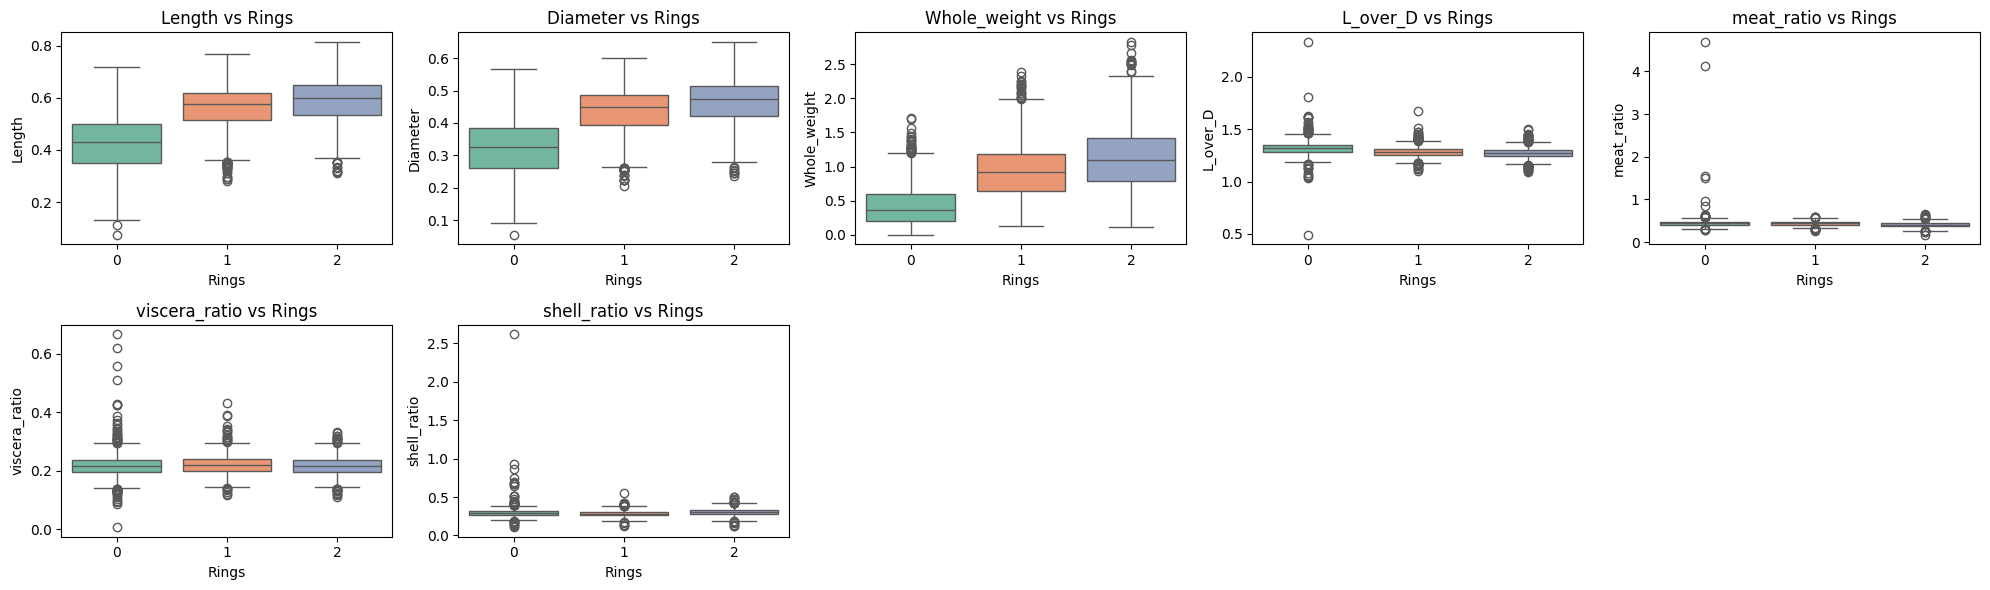

In [ ]:
draw_boxplots(df_lin, 'Rings', n_cols=5)

Удалим выбросы

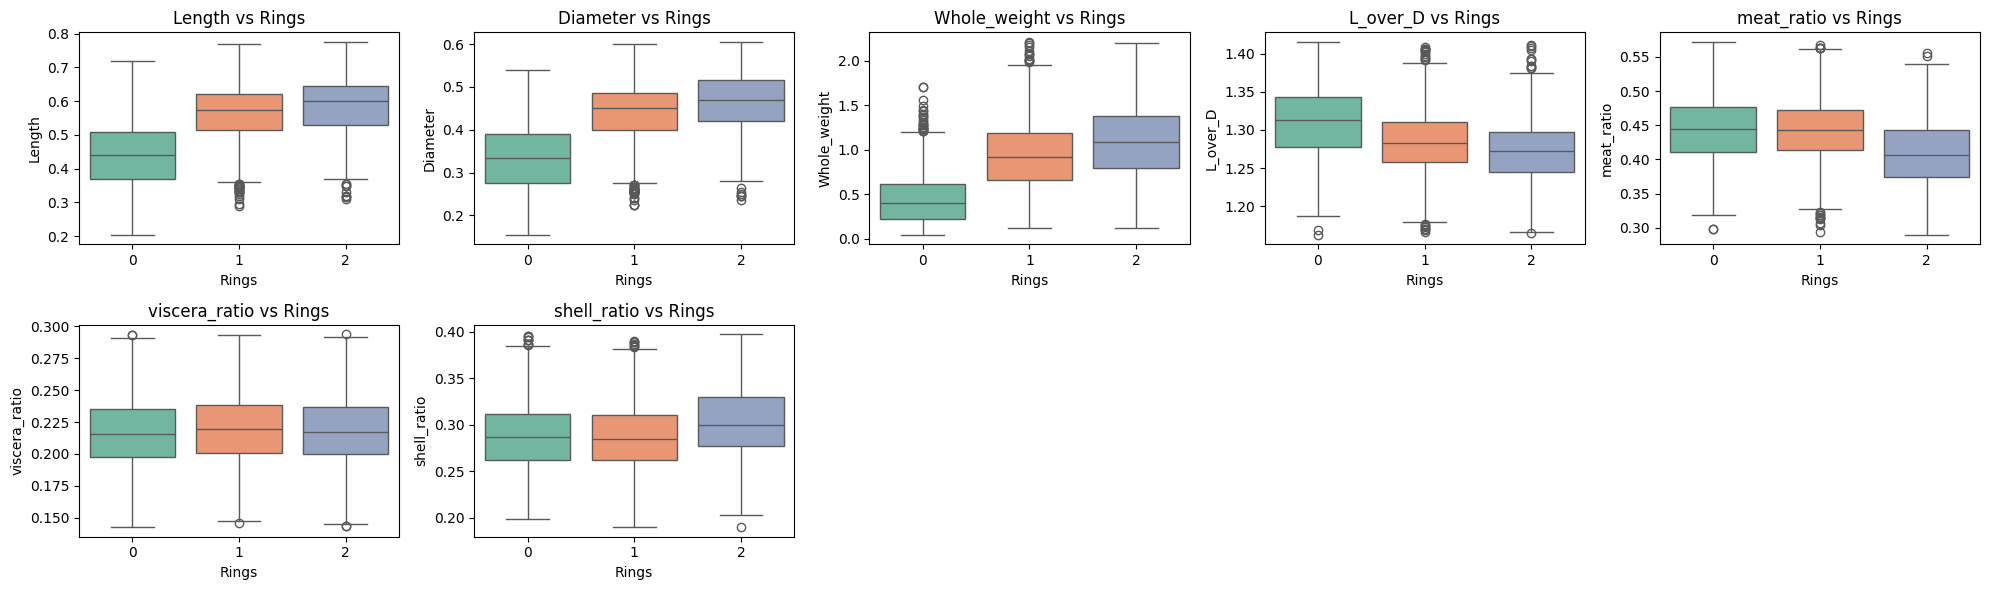

In [ ]:
df_lin = remove_outliers_iqr(df_lin, df_lin.select_dtypes(include=['float', 'int']).columns.drop('Rings'), 0.25, 0.75)
draw_boxplots(df_lin, 'Rings', n_cols=5)

#### 2.3.4. Посмотрим на скошенные столбцы справа

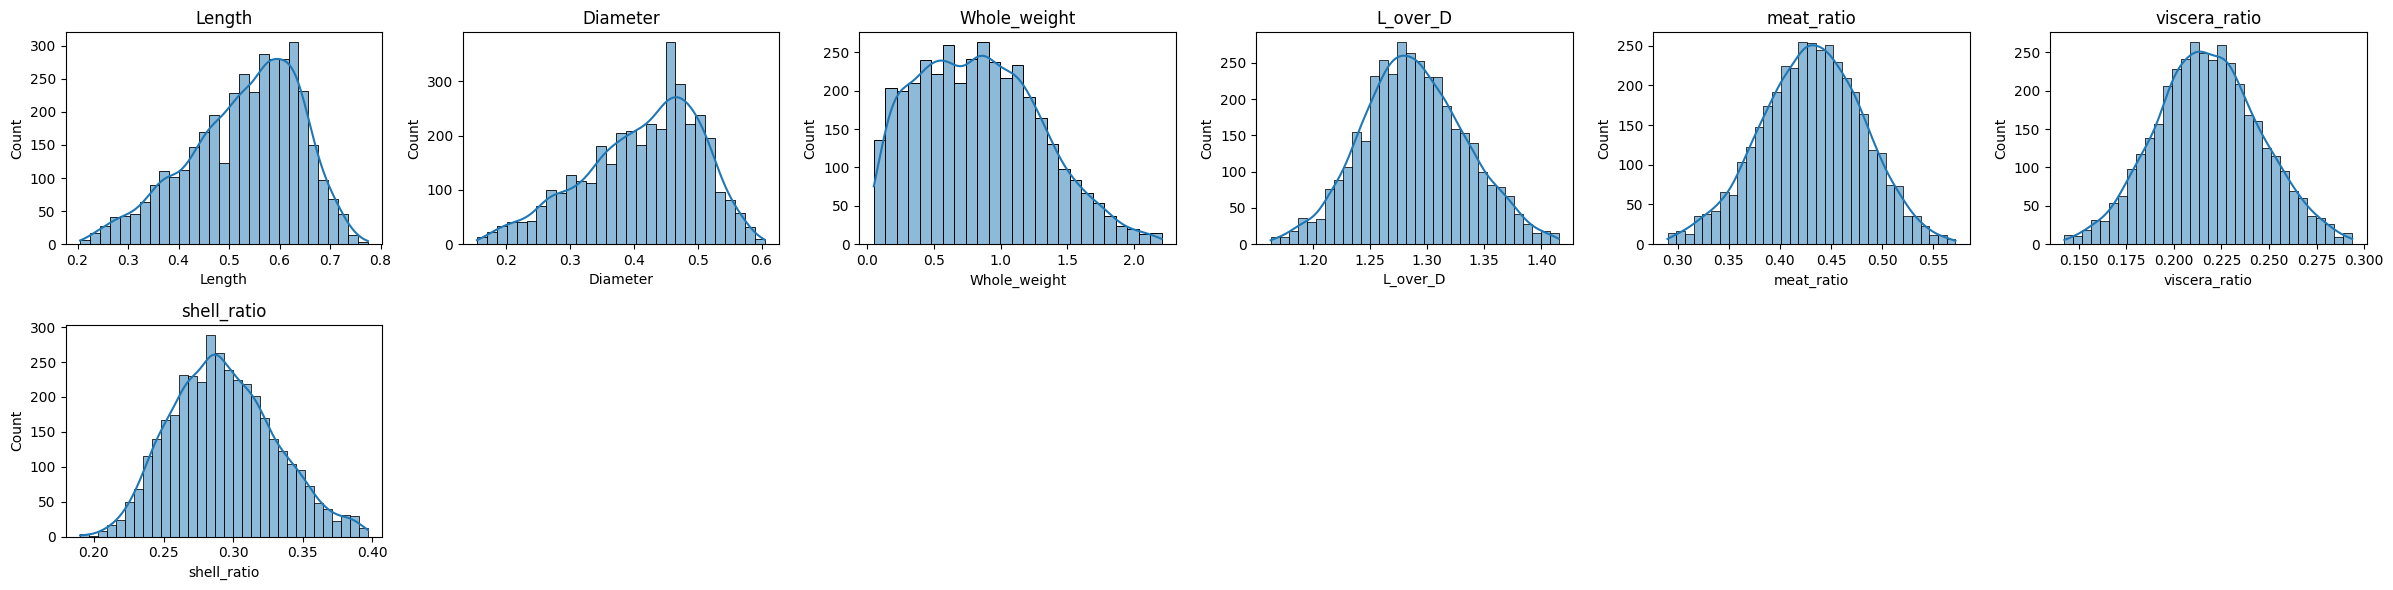

In [ ]:
draw_hist(df_lin)

Пытаемся выровнять

In [ ]:
skew_values = df_lin.skew()
skew_values_hard = skew_values[abs(skew_values) > 0.5]
skew_values_hard.index

Index(['Length', 'Diameter', 'Sex_F'], dtype='object')

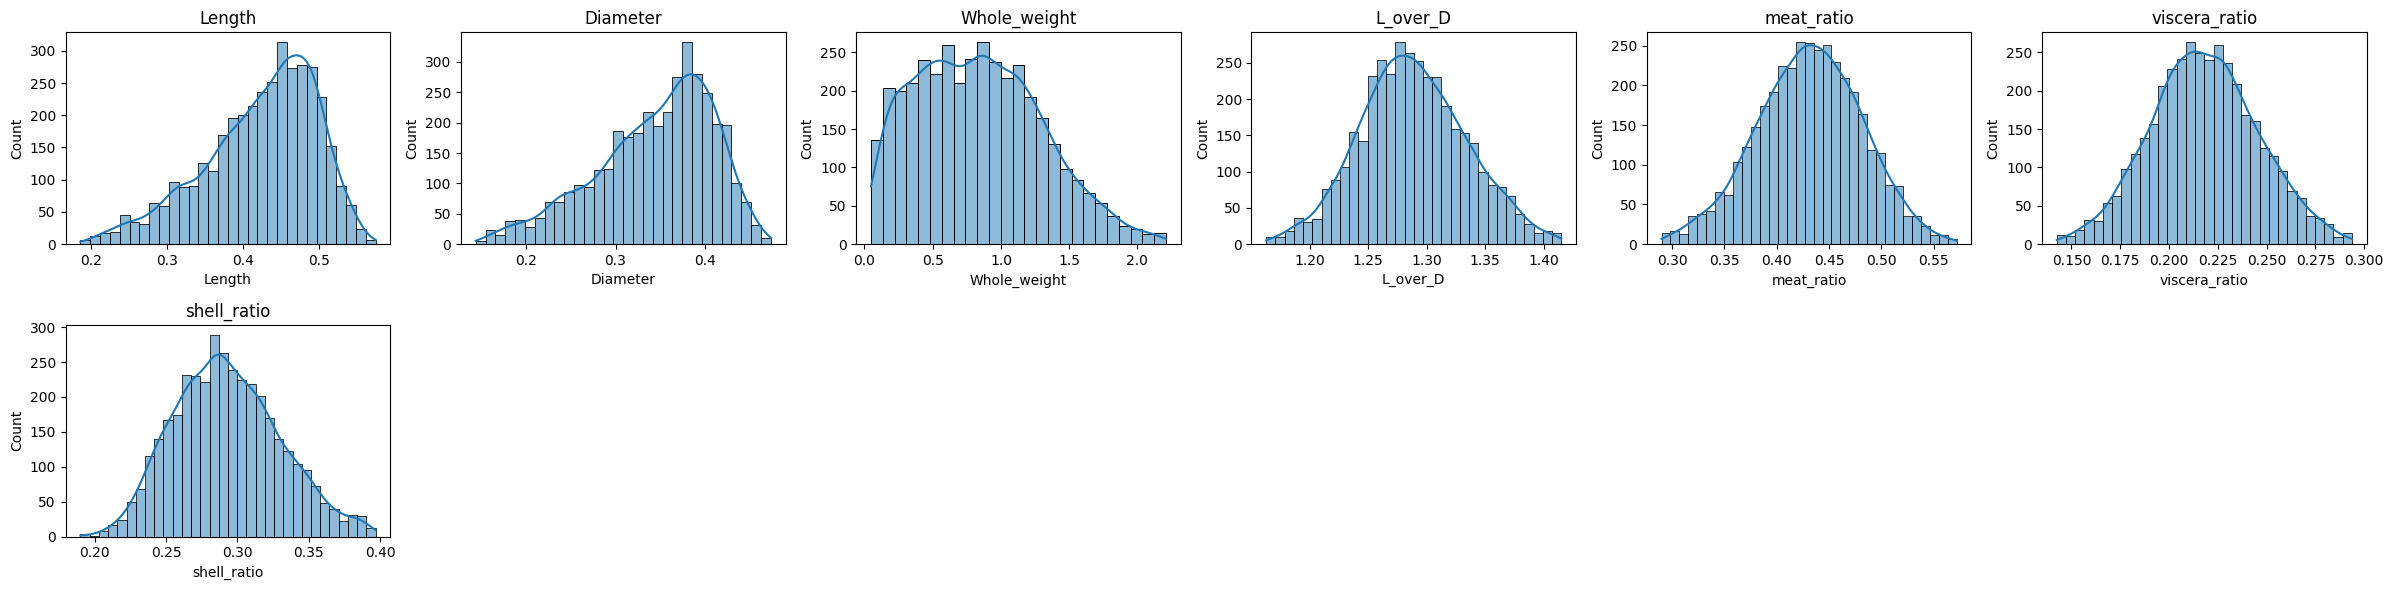

In [ ]:
df_lin = prepare_skew(df = df_lin, columns = list(skew_values_hard.index))
draw_hist(df_lin)

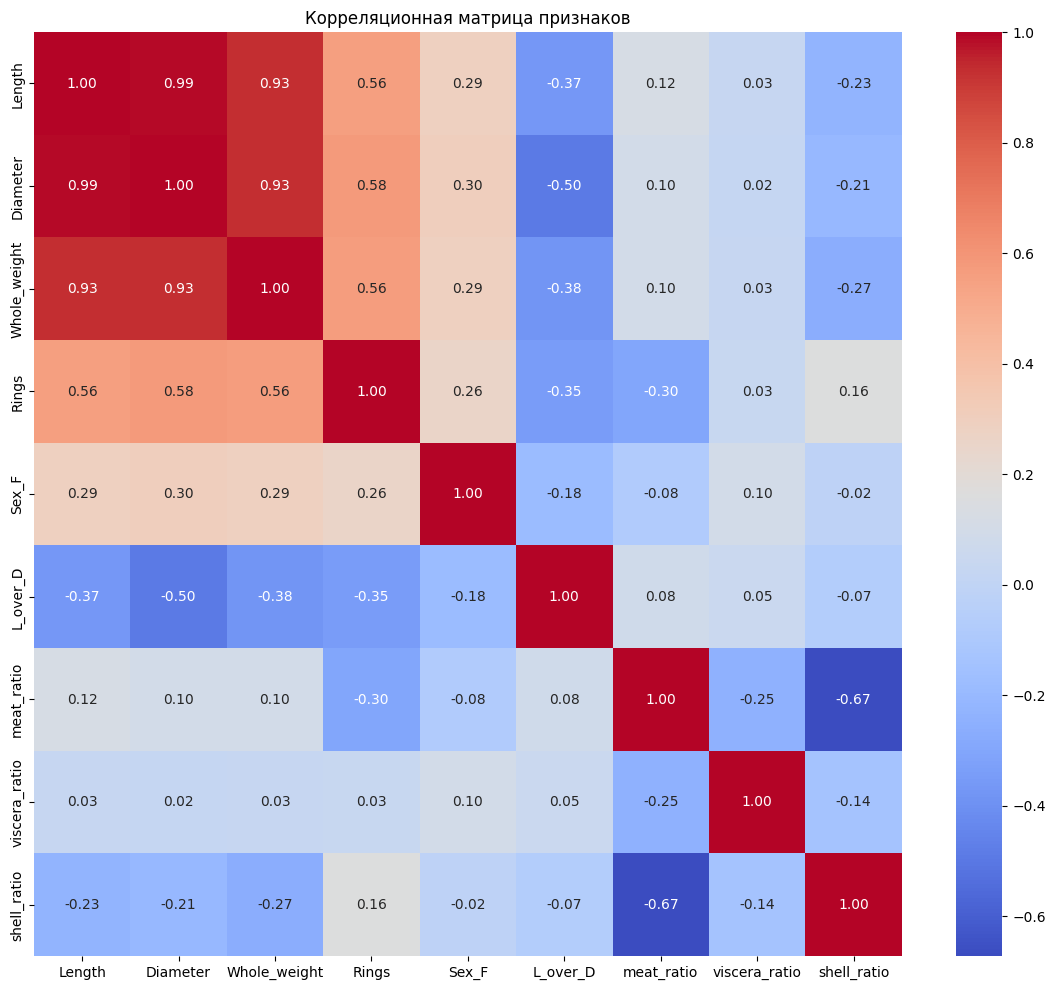

In [ ]:
draw_corr_matrix(df_lin)

### 2.4. Разделение вида Фичи - Таргет

Для: `SVM`, `Linear Binary Classification`, `KNN`

In [ ]:
y_lin = df_lin['Rings']
X_lin = df_lin.drop('Rings', axis=1)
display(X_lin.head(3), y_lin.head(3))

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,Length,Diameter,Whole_weight,Sex_F,L_over_D,meat_ratio,viscera_ratio,shell_ratio
0,0.375006,0.311154,0.5140,0.000000,1.246575,0.436770,0.196498,0.291829
1,0.300105,0.235072,0.2255,0.000000,1.320755,0.441242,0.215078,0.310421
2,0.425268,0.350657,0.6770,0.693359,1.261905,0.378877,0.209010,0.310192


,Rings
0,2
1,0
2,1


Для: `Desicion Tree`, `Random Forest` и `Gradient's Boosting Methods`

In [ ]:
y = df['Rings']
X = df.drop('Rings', axis=1)
display(X.head(3), y.head(3))

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_F,Sex_I,Sex_M,L_over_D,meat_ratio,viscera_ratio,shell_ratio
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,False,False,True,1.246575,0.436770,0.196498,0.291829
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,False,False,True,1.320755,0.441242,0.215078,0.310421
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.21,True,False,False,1.261905,0.378877,0.209010,0.310192


,Rings
0,2
1,0
2,1


## 3. Создание моделей

### 3.0. Создание `SVM`, `Linear Binary Classification`, `KNN`

#### Support Vector Machine

[Почитать 1](https://scikit-learn.org/stable/modules/svm.html)

[Почитать 2](https://t.me/devwhoami/179)

Метод опорных векторов (Support Vector Machine, **SVM**) — это мощный и популярный алгоритм **линейной** (и нелинейной) **классификации**.

Основная идея:

1.  **Разделяющая гиперплоскость**: SVM находит оптимальную гиперплоскость (линию в 2D, плоскость в 3D), которая **наилучшим образом разделяет** классы в вашем наборе данных.
2.  **Максимизация зазора (Margin)**: "Наилучшим образом" означает, что гиперплоскость должна находиться на **максимальном расстоянии** от ближайших точек каждого класса. Это расстояние называется **зазором (margin)**.
3.  **Опорные векторы (Support Vectors)**: Только те точки данных, которые находятся **ближе всего** к гиперплоскости и определяют ширину зазора, называются **опорными векторами**. Эти точки имеют решающее значение; если их удалить, положение гиперплоскости может измениться.
4.  **Ядерный трюк (Kernel Trick)**: Для **нелинейно** разделимых данных SVM использует так называемый **ядерный трюк**. Он неявно проецирует данные в пространство более высокой размерности, где классы становятся линейно разделимыми, и находит там оптимальную гиперплоскость.

**Кратко**: SVM строит **широчайший возможный "коридор"** между классами, опираясь только на самые сложные (граничные) точки — опорные векторы.

In [ ]:
from sklearn.svm import SVC

model_svm = SVC(
    C=1.0,           # Параметр регуляризации. Чем меньше C, тем шире зазор, тем больше ошибок допускается (сильнее регуляризация).
                     # Варианты: 0.1, 1, 10, 100.

    kernel='rbf',    # Тип ядра. Определяет, как данные будут проецироваться в пространство более высокой размерности.
                     # Варианты: 'linear' (линейный классификатор), 'poly' (полиномиальный),
                     # 'rbf' (Радиальная базисная функция - наиболее часто используется для нелинейных задач), 'sigmoid'.

    gamma='scale',   # Коэффициент ядра (для 'rbf', 'poly', 'sigmoid'). Определяет "влияние" одного обучающего примера.
                     # Варианты: 'scale' (1 / (n_features * X.var())) или 'auto' (1 / n_features) - рекомендуются по умолчанию.
                     # Или: небольшие значения (0.01, 0.1) для широкого влияния; большие значения (1, 10) для узкого влияния.

    degree=3,        # Степень полинома (для 'poly' ядра). Игнорируется для других ядер.
                     # Варианты: 2, 3, 4.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    probability=True # Включает оценку вероятности классов (медленнее, но иногда нужно).
                      # Варианты: True (если нужны предсказанные вероятности), False (по умолчанию, если нужна только классификация).
)

#### Logistic Regression

**Логистическая регрессия — краткое пояснение:**

Логистическая регрессия — это метод машинного обучения, используемый для решения задач **классификации**, то есть когда нужно предсказать, к какому классу принадлежит объект (например, «да/нет», «0/1»).

В отличие от линейной регрессии, логистическая регрессия предсказывает **вероятность принадлежности** объекта к определённому классу. Для этого используется **логистическая (сигмоидная) функция**, которая преобразует линейную комбинацию признаков в значение от 0 до 1.

Основные шаги:

1. Строится линейная модель:
    $$z = w_0 + w_1x_1 + w_2x_2 + ... + w_nx_n$$
2. К результату применяется сигмоида:
   $$p = \frac{1}{1 + e^{-z}}$$
3. Если ($p > 0.5$), то объект относят к классу 1, иначе — к классу 0.

Модель обучается с помощью **максимизации правдоподобия** (обычно через метод градиентного спуска).


In [ ]:
from sklearn.linear_model import LogisticRegression

model_logreg = LogisticRegression(
    penalty='l2',        # Тип регуляризации, добавляемой для предотвращения переобучения.
                         # 'l2' — стандартная (ридж-регуляризация), 'l1' — лассо-регуляризация (зануляет некоторые коэффициенты).
                         # Варианты: 'l1', 'l2', 'elasticnet', 'none'.

    C=1.0,               # Обратный коэффициент силы регуляризации.
                         # Чем меньше C — тем сильнее регуляризация (жестче штраф за большие коэффициенты).
                         # Варианты: 0.01, 0.1, 1, 10, 100.

    solver='lbfgs',      # Алгоритм оптимизации для нахождения весов модели.
                         # 'lbfgs' — универсальный и быстрый (подходит для малых и средних наборов данных).
                         # Другие варианты: 'liblinear' (поддерживает L1), 'saga' (работает с большими данными и L1/L2), 'newton-cg'.

    max_iter=1000,        # Максимальное число итераций для сходимости алгоритма.
                         # Если обучение не сходится — увеличить, например до 500.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов (фиксирует начальные веса).

    fit_intercept=True,  # Добавляет свободный коэффициент (смещение) в модель.
                         # Обычно True, чтобы учитывать среднее значение признаков.

    n_jobs=None          # Количество потоков для параллельных вычислений.
                         # None — одно ядро, -1 — использовать все доступные ядра процессора.
)

#### K-Nearest Neighbors (KNN)

**Метод k-ближайших соседей — краткое пояснение:**

KNN (*k-nearest neighbors*) — это простой и интуитивный метод машинного обучения, применяемый для задач **классификации** и **регрессии**.
Он не строит явной модели — вместо этого принимает решение, основываясь на **схожести объектов** в пространстве признаков.

Идея метода:
Для нового объекта алгоритм ищет **k ближайших соседей** из обучающей выборки (по выбранной метрике расстояния) и определяет класс по **голосованию** этих соседей.

Основные шаги:

1. Выбирается число соседей $k$ — например, 3 или 5.
2. Для нового объекта вычисляются расстояния до всех объектов обучающей выборки.
3. Определяются $k$ ближайших точек.
4. Класс объекта определяется по большинству классов среди соседей.

Метод KNN **не имеет этапа обучения**, так как просто запоминает обучающие данные.
Основной параметр, влияющий на качество модели — это число соседей $k$:

* Малое $k$ делает модель чувствительной к шуму.
* Большое $k$ сглаживает границы между классами.


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

model_knn = KNeighborsClassifier(
    n_neighbors=5,      # Количество ближайших соседей (k).
                        # Малое значение делает модель чувствительной к шуму, большое — сглаживает предсказания.
                        # Варианты: 3, 5, 7, 9 и т.д.

    weights='uniform',  # Веса соседей при голосовании.
                        # 'uniform' — все соседи равны,
                        # 'distance' — соседи ближе к объекту имеют больший вес.

    metric='minkowski', # Метрика расстояния.
                        # По умолчанию 'minkowski' с p=2 соответствует евклидову расстоянию.
                        # Варианты: 'euclidean', 'manhattan', 'chebyshev', 'minkowski'.

    p=2,                # Степень метрики Минковского (p=1 — манхэттен, p=2 — евклид).
                        # Меняется только если выбран 'minkowski'.

    algorithm='auto',   # Алгоритм поиска ближайших соседей.
                        # 'auto' выбирает оптимальный метод (ball_tree, kd_tree, brute) в зависимости от данных.

    n_jobs=None         # Количество потоков для вычислений.
                        # None — одно ядро, -1 — использовать все доступные ядра процессора.
)

### 3.1. Создание `Desicion Tree`, `Random Forest`

#### Decision Tree Classifier (Дерево решений)

**Дерево решений — краткое пояснение:**

Дерево решений — это алгоритм **классификации и регрессии**, который принимает решения, разбивая данные по признакам в виде **дерева с узлами и ветвями**.
Каждый узел дерева соответствует условию на значение признака (например, «возраст > 30?»), а листья — это **предсказанные классы**.

Идея метода:
Алгоритм рекурсивно делит выборку на подмножества так, чтобы в каждом из них объекты как можно больше принадлежали одному классу.
Критерием “хорошего разбиения” служат меры **чистоты узла** — например, *Gini* или *энтропия*.

Основные шаги:

1. Выбирается признак и порог, которые лучше всего разделяют данные по целевой переменной.
2. Создаются новые ветви для каждого значения или диапазона признака.
3. Процесс повторяется до тех пор, пока не достигнуты условия остановки (например, максимальная глубина).
4. Листовые узлы содержат итоговые классы.

Преимущества:

* Простая интерпретация (можно визуализировать дерево).
* Не требует масштабирования данных.

Недостатки:

* Склонно к **переобучению**, особенно при большой глубине дерева.
* Может быть нестабильным (небольшие изменения данных → другое дерево).

In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_tree = DecisionTreeClassifier(
    criterion='gini',       # Критерий качества разбиения.
                            # 'gini' — индекс Джини (по умолчанию),
                            # 'entropy' — энтропия (информационный выигрыш),
                            # 'log_loss' — основан на логарифмической потере.

    splitter='best',        # Стратегия выбора признака для разбиения.
                            # 'best' — выбирает наилучшее разбиение,
                            # 'random' — выбирает случайный признак (для ускорения и разнообразия).

    max_depth=None,         # Максимальная глубина дерева.
                            # None — без ограничения (может привести к переобучению).
                            # Примеры: 3, 5, 10.

    min_samples_split=2,    # Минимальное число образцов для разбиения узла.
                            # Увеличение этого параметра уменьшает переобучение.

    min_samples_leaf=1,     # Минимальное количество образцов в листе.
                            # Увеличение значения делает дерево более “гладким”.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    max_features=None,      # Количество признаков, рассматриваемых при каждом разбиении.
                            # None — использовать все признаки.

    class_weight=None       # Веса классов для компенсации дисбаланса.
                            # Например: 'balanced' — автоматически выравнивает частоты классов.
)


#### Random Forest Classifier (Случайный лес)

**Случайный лес — краткое пояснение:**

Случайный лес — это ансамблевый метод машинного обучения, основанный на **множестве деревьев решений**, каждое из которых обучается независимо на случайных подвыборках данных и признаков.
Модель объединяет результаты всех деревьев (обычно **путём голосования**) для получения более устойчивого и точного предсказания.

Идея метода:
Вместо одного дерева (которое может переобучаться), алгоритм строит **множество случайных деревьев**, каждое из которых "смотрит" на разные части данных.
В результате снижается разброс модели и повышается обобщающая способность.

Основные шаги:

1. Из исходных данных случайно выбираются подмножества объектов (методом *bootstrap*).
2. Для каждого дерева случайно выбирается подмножество признаков.
3. Каждое дерево строится независимо, как обычное дерево решений.
4. При классификации итоговый класс выбирается **по большинству голосов деревьев**.

Преимущества:

* Устойчив к переобучению.
* Хорошо работает “из коробки” без сильной настройки параметров.
* Может оценивать важность признаков (*feature importance*).

Недостатки:

* Менее интерпретируем, чем одно дерево.
* Медленнее при очень больших данных.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_forest = RandomForestClassifier(
    n_estimators=100,        # Количество деревьев в лесе.
                             # Большее число деревьев обычно улучшает качество, но увеличивает время обучения.
                             # Варианты: 50, 100, 200, 500.

    criterion='gini',        # Критерий качества разбиений для каждого дерева.
                             # 'gini' — индекс Джини (по умолчанию),
                             # 'entropy' — энтропия.

    max_depth=None,          # Максимальная глубина каждого дерева.
                             # None — без ограничения (может переобучаться).
                             # Примеры: 5, 10, 20.

    min_samples_split=2,     # Минимальное количество образцов для разбиения узла.
                             # Увеличение уменьшает переобучение.

    min_samples_leaf=1,      # Минимальное количество образцов в листе.
                             # Увеличение делает модель более "плавной".

    max_features='sqrt',     # Количество признаков, используемых при поиске лучшего разбиения.
                             # 'sqrt' — стандарт для классификации (корень из числа признаков).
                             # 'log2' — логарифм по основанию 2, или число/доля признаков.

    bootstrap=True,          # Использовать ли bootstrap-подвыборки при обучении деревьев.
                             # True — стандартный вариант, False — использовать все данные.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    n_jobs=None,             # Количество потоков.
                             # None — одно ядро, -1 — использовать все ядра процессора.

    class_weight=None        # Веса классов для компенсации дисбаланса.
                             # 'balanced' — автоматически выравнивает частоты классов.
)

### 3.2. Создание `Gradient's Boosting Methods`

#### Gradient Boosting Classifier (Градиентный бустинг)

**Градиентный бустинг — краткое пояснение:**

Градиентный бустинг — это **ансамблевый метод**, который строит **последовательность слабых моделей** (обычно небольших деревьев решений), где каждая новая модель **исправляет ошибки предыдущих**.
В отличие от случайного леса, где деревья строятся **независимо**, в бустинге каждое следующее дерево обучается **на остатках (ошибках)** предыдущих.

Идея метода:

1. Обучается первое дерево, которое делает начальные предсказания.
2. Вычисляются ошибки (разница между предсказанными и истинными значениями).
3. Следующее дерево обучается предсказывать эти ошибки.
4. Итоговое предсказание — сумма (или взвешенная комбинация) всех деревьев.

Благодаря этому модель постепенно **минимизирует функцию потерь** и достигает высокой точности.

Преимущества:

* Очень высокая точность при правильной настройке.
* Хорошо работает с числовыми и категориальными признаками.
* Можно контролировать переобучение через глубину деревьев и скорость обучения.

Недостатки:

* Медленнее в обучении, чем случайный лес.
* Требует подбора гиперпараметров.
* Может переобучаться при слишком большом количестве деревьев.

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model_gb = GradientBoostingClassifier(
    loss='log_loss',        # Функция потерь, которую минимизирует алгоритм.
                            # 'log_loss' — для классификации (по умолчанию),
                            # 'exponential' — аналог AdaBoost.

    learning_rate=0.1,      # Скорость обучения (вклад каждого дерева в общий результат).
                            # Меньшие значения (0.01–0.1) делают обучение стабильнее, но требуют больше деревьев.

    n_estimators=100,       # Количество слабых моделей (деревьев).
                            # Большее число может повысить точность, но и риск переобучения.

    subsample=1.0,          # Доля выборки, используемая для обучения каждого дерева.
                            # Значения < 1.0 добавляют стохастичность (ускоряют и уменьшают переобучение).

    criterion='friedman_mse', # Критерий качества разбиений.
                              # 'friedman_mse' — оптимальный для бустинга,
                              # 'squared_error' и 'mse' — классические варианты.

    min_samples_split=2,    # Минимальное число образцов для разбиения узла.

    min_samples_leaf=1,     # Минимальное число образцов в листе.

    max_depth=3,            # Максимальная глубина базовых деревьев.
                            # Малые значения (3–5) обычно предотвращают переобучение.

    random_state=RANDOM_STATE, # Для воспроизводимости результатов.

    max_features=None,      # Количество признаков при разбиении.
                            # None — использовать все признаки, 'sqrt' или 'log2' — случайное подмножество.

    verbose=0               # Если >0, выводит процесс обучения (для отладки).
)


#### XGBoost (Extreme Gradient Boosting)

**XGBoost — краткое пояснение:**

**XGBoost (Extreme Gradient Boosting)** — это усовершенствованная реализация градиентного бустинга, созданная для **скорости, эффективности и точности**.
Он работает по тем же принципам, что и обычный **Gradient Boosting**, но добавляет оптимизации на уровне вычислений, регуляризации и обработки пропусков.

XGBoost строит ансамбль из множества **деревьев решений**, каждое из которых **исправляет ошибки предыдущих**, минимизируя функцию потерь с помощью **градиентного спуска**.

Особенности XGBoost:

* Использует **L1 и L2 регуляризацию**, что снижает переобучение.
* Поддерживает **параллельное обучение** деревьев.
* Эффективно работает с **пропущенными данными**.
* Может применяться не только для классификации, но и для регрессии, ранжирования и др.

Преимущества:

* Очень высокая точность.
* Быстрее классического `GradientBoostingClassifier`.
* Гибкость — множество гиперпараметров для точной настройки.

Недостатки:

* Сложнее в настройке.
* Требует больше памяти и вычислительных ресурсов.


In [ ]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    n_estimators=100,        # Количество деревьев (итераций бустинга).
                            # Увеличение может повысить качество, но и риск переобучения.

    learning_rate=0.1,       # Скорость обучения (вклад каждого дерева).
                            # Меньшие значения (0.01–0.1) требуют большего числа деревьев.

    max_depth=3,             # Максимальная глубина деревьев.
                            # Контролирует сложность модели — большее значение → выше риск переобучения.

    subsample=1.0,           # Доля выборки, используемая при построении каждого дерева.
                            # Меньше 1.0 → случайность и снижение переобучения.

    colsample_bytree=1.0,    # Доля признаков, выбираемых при построении каждого дерева.
                            # Обычно 0.8–1.0 — для ускорения и устойчивости.

    gamma=0,                 # Минимальное улучшение функции потерь для разбиения узла.
                            # Увеличение gamma делает модель более консервативной.

    reg_alpha=0,             # L1-регуляризация (на коэффициенты).
                            # Увеличение помогает убрать незначимые признаки.

    reg_lambda=1,            # L2-регуляризация (по умолчанию).
                            # Контролирует переобучение через штраф на большие веса.

    objective='multi:softmax', # Функция потерь.
                                 # 'binary:logistic' — для бинарной классификации (0/1),
                                 # 'multi:softmax' — для многоклассовой (требует num_class).

    random_state=RANDOM_STATE,   # Для воспроизводимости результатов.

    n_jobs=-1,              # Использовать все ядра процессора для ускорения обучения.

    verbosity=0             # Уровень вывода (0 — без вывода, 1–3 — подробные логи).
)

#### CatBoost Classifier (Categorical Boosting, от Яндекса)

**CatBoost** — это современный алгоритм **градиентного бустинга**, разработанный компанией **Яндекс**.
Название расшифровывается как *“Categorical Boosting”*, поскольку он изначально создан для **работы с категориальными признаками** — без необходимости их кодировать вручную (в отличие от XGBoost или LightGBM).

CatBoost строит ансамбль **решающих деревьев**, где каждое следующее дерево **исправляет ошибки предыдущих**, используя метод **градиентного спуска**.
Главная особенность — **эффективная обработка категориальных данных** и **устойчивость к переобучению**.

**Особенности CatBoost:**

* Автоматически кодирует категориальные признаки (*“target encoding with permutations”*).
* Использует **симметричные деревья** (каждое разбиение делается одинаково по всем ветвям), что ускоряет предсказания.
* Встроенная **регуляризация** и **устойчивость к переобучению**.
* Поддерживает **GPU-ускорение** и многопоточность.

**Преимущества:**

* Работает “из коробки” без сложной подготовки данных.
* Часто требует меньше настройки гиперпараметров.
* Высокая точность и скорость обучения.

**Недостатки:**

* Более “тяжёлый” по памяти, чем простые модели.
* Для очень больших данных может быть медленнее LightGBM.


In [ ]:
from catboost import CatBoostClassifier

model_cat = CatBoostClassifier(
    iterations=259,         # Количество деревьев (итераций бустинга).
                             # Увеличение может повысить точность, но и время обучения.

    learning_rate=0.071,       # Скорость обучения.
                             # Малые значения (0.01–0.1) делают обучение стабильнее, но дольше.

    depth=5,                 # Глубина деревьев.
                             # Контролирует сложность модели (типично 4–10).

    loss_function='MultiClass', # Функция потерь (для бинарной классификации).
                             # 'Logloss' — бинарная, 'MultiClass' — многоклассовая.

    l2_leaf_reg=3.38,         # Коэффициент L2-регуляризации.
                             # Повышение снижает переобучение.

    random_seed=RANDOM_STATE, # Для воспроизводимости.

    bootstrap_type='MVS', # Метод подвыборки данных при обучении.
                               # 'Bayesian' — по умолчанию, 'Bernoulli', 'MVS' —  альтернативы.

    subsample=0.882,           # Доля данных, используемая для каждого дерева.
                             # Меньше 1.0 — для стохастичности и борьбы с переобучением.

    verbose=0,             # Как часто выводить прогресс обучения (итерации).
                             # 0 — без вывода.

    cat_features=None,       # Список индексов категориальных признаков.
                             # Можно не указывать, если CatBoost сам их определяет.

    task_type='CPU'          # Тип устройства для обучения: 'CPU' или 'GPU'.
)

In [ ]:
import optuna
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import numpy as np

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0),
        'random_seed': RANDOM_STATE,
        'verbose': 0,
        'loss_function': 'MultiClass',
        'eval_metric': 'MultiClass',
        'custom_metric': 'F1',
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian', 'Bernoulli', 'MVS'])
    }

    if params['bootstrap_type'] in ['Bernoulli', 'MVS']:
        params['subsample'] = trial.suggest_float('subsample', 0.6, 1.0)


    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    f1_scores = []

    X_values = df.drop(columns='Rings').values
    y_values = df['Rings'].values

    for col in df.drop(columns='Rings').columns:
        if df[col].dtype == bool:
            X_values[:, df.drop(columns='Rings').columns.get_loc(col)] = X_values[:, df.drop(columns='Rings').columns.get_loc(col)].astype(int)


    for train_index, test_index in kf.split(X_values, y_values):
        X_train, X_test = X_values[train_index], X_values[test_index]
        y_train, y_test = y_values[train_index], y_values[test_index]

        model = CatBoostClassifier(**params)
        model.fit(X_train, y_train, early_stopping_rounds=50, eval_set=[(X_test, y_test)], verbose=0) # Use eval_set and early_stopping

        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='macro')
        f1_scores.append(f1)

    return np.mean(f1_scores)

In [ ]:

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
print("  Value: {:.3f}".format(study.best_trial.value))
print("  Params: ")
for key, value in study.best_trial.params.items():
    print("    {}: {}".format(key, value))


[I 2025-11-06 01:51:13,299] A new study created in memory with name: no-name-e11502ed-6fe7-461d-8ecb-1e6991a36c89
[I 2025-11-06 01:51:16,010] Trial 0 finished with value: 0.6680640267179103 and parameters: {'iterations': 801, 'learning_rate': 0.1306541657444918, 'depth': 4, 'l2_leaf_reg': 3.1856735006447074, 'bootstrap_type': 'Bernoulli', 'subsample': 0.7952814997015842}. Best is trial 0 with value: 0.6680640267179103.
[I 2025-11-06 01:51:22,565] Trial 1 finished with value: 0.6647603135303188 and parameters: {'iterations': 828, 'learning_rate': 0.2519066199515508, 'depth': 7, 'l2_leaf_reg': 7.293726828867923, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.6680640267179103.
[I 2025-11-06 01:51:37,535] Trial 2 finished with value: 0.6685430697818086 and parameters: {'iterations': 708, 'learning_rate': 0.023007602685125715, 'depth': 5, 'l2_leaf_reg': 5.005280110716809, 'bootstrap_type': 'MVS', 'subsample': 0.8080256542939283}. Best is trial 2 with value: 0.6685430697818086.

Best trial:
  Value: 0.675
  Params: 
    iterations: 608
    learning_rate: 0.11321701218075271
    depth: 6
    l2_leaf_reg: 9.955867734066342
    bootstrap_type: Bayesian


## 4. Обучение и прогонка

Реализуем пайплайн тестирования

In [ ]:
# Функция для вычисления метрик
def evaluate_metrics(y_true, y_pred, y_proba=None):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics["f1_macro"] = f1_score(y_true, y_pred, average="macro")
    metrics["f1_weighted"] = f1_score(y_true, y_pred, average="weighted")

    if y_proba is not None:
      if hasattr(y_proba, 'ndim') and getattr(y_proba, 'ndim', 1) == 2 and y_proba.shape[1] > 1:
          metrics['roc_auc_ovr_macro'] = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
      else:
          metrics['roc_auc'] = roc_auc_score(y_true, y_proba)

    return metrics

In [ ]:
def plot_roc(y_true, y_proba, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
def test_models_pipeline(df, target_col, models_dict, n_splits=5, random_state=RANDOM_STATE):
    """
    Пайплайн тестирования моделей с Cross-Validation, метриками, визуализацией разделяющей поверхности и ROC-AUC.

    Parameters:
        df : pd.DataFrame
            Датафрейм с признаками и целевой переменной.
        target_col : str
            Название колонки с целевой переменной.
        models_dict : dict
            Словарь моделей в формате {"ModelName": model_instance}.
        n_splits : int
            Количество фолдов для Stratified K-Fold CV.
        random_state : int
            Для воспроизводимости.
    """

    X = df.drop(columns=target_col).values
    y = df[target_col].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for name, model in models_dict.items():
        acc_list, f1_list, roc_list = [], [], []

        for train_idx, test_idx in kf.split(X_scaled, y):
            X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            model.fit(X_train, y_train)

            y_pred = model.predict(X_test)
            y_proba = None

            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)

            metrics = evaluate_metrics(y_test, y_pred, y_proba)
            acc_list.append(metrics['accuracy'])
            f1_list.append(metrics['f1_macro'])
            if 'roc_auc' in metrics:
               roc_list.append(metrics['roc_auc'])
            if 'roc_auc_ovr_macro' in metrics:
               roc_list.append(metrics['roc_auc_ovr_macro'])


        # Вывод метрик
        print(f"=== {name} ===")
        print(f"Accuracy: {np.mean(acc_list):.3f} ± {np.std(acc_list):.3f}")
        print(f"F1-macro: {np.mean(f1_list):.3f} ± {np.std(f1_list):.3f}")
        if roc_list:
           print(f"ROC-AUC: {np.mean(roc_list):.3f} ± {np.std(roc_list):.3f}")

In [ ]:
def plot_fixed_feature_decision_surface(df, target_col, model, fixed_feature, feature_names=None, n_cols=3):
    """
    Строит scatterplot с разделяющей поверхностью для фиксированного признака против всех остальных.

    Parameters:
        df : pd.DataFrame
            Датафрейм с признаками и целевой переменной.
        target_col : str
            Название колонки с целевой переменной.
        model : sklearn estimator
            Обученная модель классификации.
        fixed_feature : str
            Название признака, который будет "фиксированным".
        feature_names : list or None
            Список признаков. Если None, берутся все колонки кроме target.
        n_cols : int
            Количество графиков на строку.
    """

    if feature_names is None:
        feature_names = [c for c in df.columns if c != target_col]

    if fixed_feature not in feature_names:
        raise ValueError(f"{fixed_feature} не найден в признаках")

    X = df[feature_names].values
    y = df[target_col].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    fixed_idx = feature_names.index(fixed_feature)
    other_indices = [i for i in range(len(feature_names)) if i != fixed_idx]

    n_plots = len(other_indices)
    n_rows = int(np.ceil(n_plots / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    axes = axes.flatten()

    for k, j in enumerate(other_indices):
        X_pair = X_scaled[:, [fixed_idx, j]]
        model.fit(X_pair, y)

        x_min, x_max = X_pair[:, 0].min() - 1, X_pair[:, 0].max() + 1
        y_min, y_max = X_pair[:, 1].min() - 1, X_pair[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                             np.linspace(y_min, y_max, 200))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        ax = axes[k]
        ax.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
        scatter = ax.scatter(X_pair[:,0], X_pair[:,1], c=y, cmap=plt.cm.coolwarm, edgecolor="k")
        ax.set_xlabel(fixed_feature)
        ax.set_ylabel(feature_names[j])
        ax.set_title(f"{model.__class__.__name__}: {fixed_feature} vs {feature_names[j]}")

    # Если графиков меньше, чем ячеек subplots
    for m in range(k+1, len(axes)):
        fig.delaxes(axes[m])

    plt.tight_layout()
    plt.show()


### 4.0 Обучение и тесты моделей \{SVM, Logistic Regression, KNN\}

In [ ]:
# Список моделей
models = {
    "SVM": model_svm,
    "Logistic Regression": model_logreg,
    "KNN": model_knn
}

test_models_pipeline(df_lin, target_col='Rings', models_dict=models, n_splits=5, random_state=RANDOM_STATE)

=== SVM ===
Accuracy: 0.646 ± 0.018
F1-macro: 0.647 ± 0.017
ROC-AUC: 0.823 ± 0.012
=== Logistic Regression ===
Accuracy: 0.651 ± 0.013
F1-macro: 0.650 ± 0.012
ROC-AUC: 0.830 ± 0.013
=== KNN ===
Accuracy: 0.608 ± 0.018
F1-macro: 0.608 ± 0.016
ROC-AUC: 0.774 ± 0.016


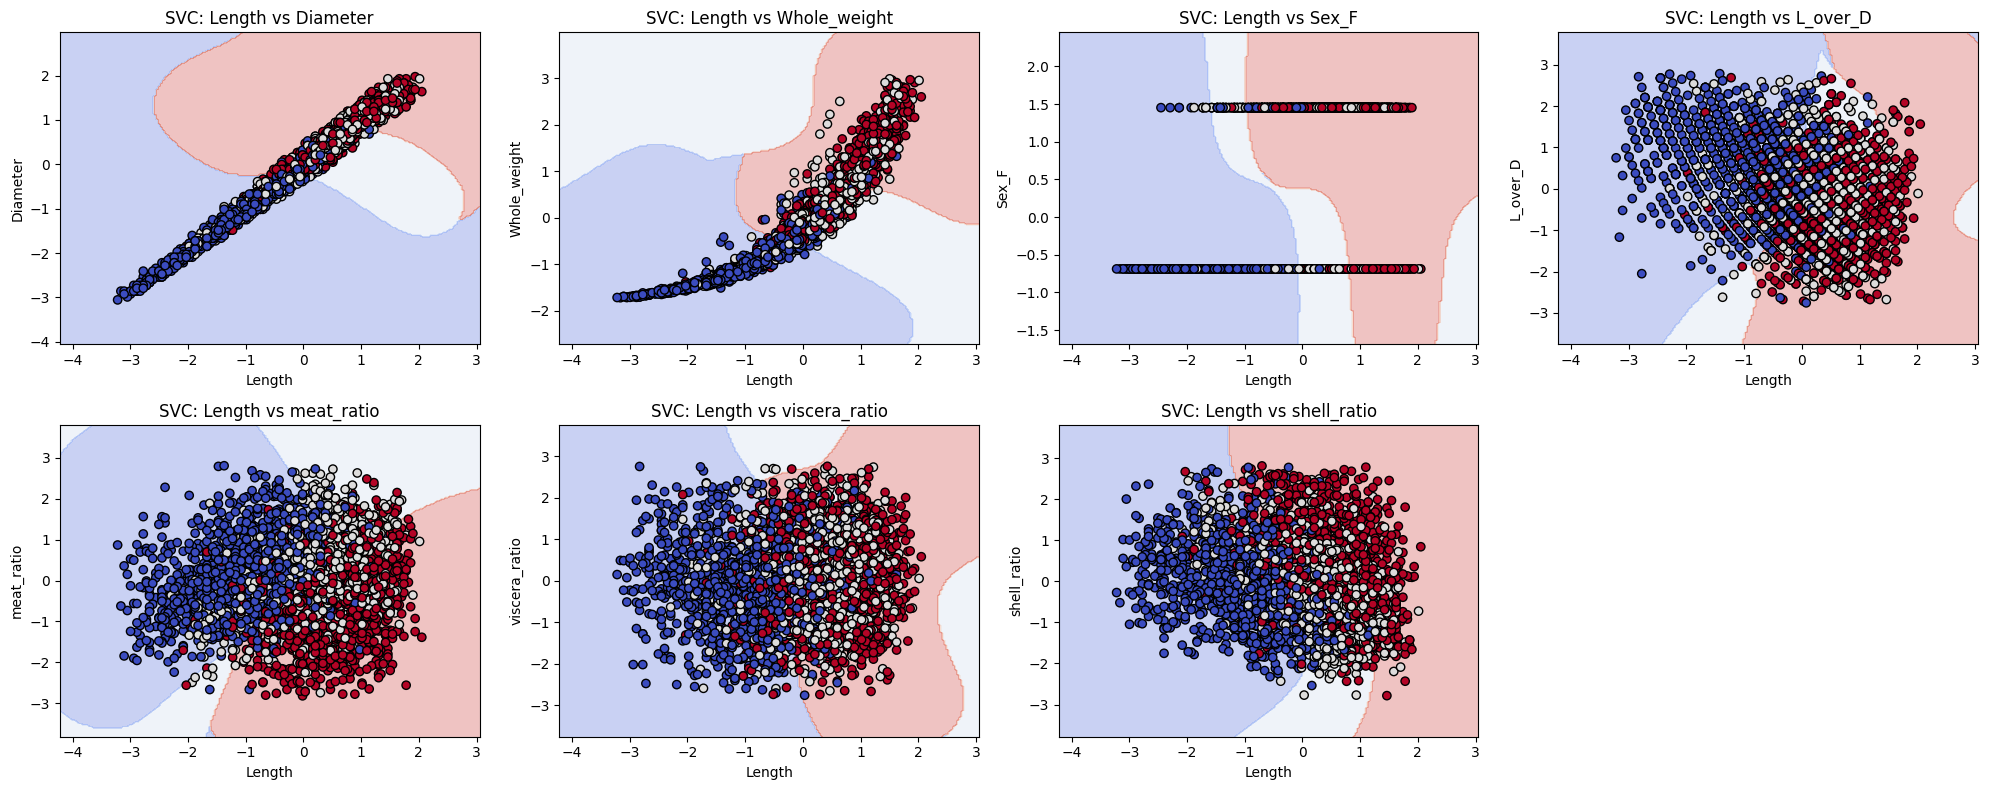

In [ ]:
plot_fixed_feature_decision_surface(
    df=df_lin,
    target_col='Rings',
    model=model_svm,
    fixed_feature='Length',
    n_cols=4
)

### 4.1 Обучение и тесты моделей \{Desicion Tree, Random Forest\}

In [ ]:
# Список моделей
models = {
    "DesicionTree": model_tree,
    "RandomForest": model_forest
}

test_models_pipeline(df, target_col='Rings', models_dict=models, n_splits=5, random_state=RANDOM_STATE)

In [ ]:
plot_fixed_feature_decision_surface(
    df=df,
    target_col='Rings',
    model=model_forest,
    fixed_feature='Length',
    n_cols=4
)

### 4.2 Обучение и тесты моделей \{Boosting Classifier, XGBoost, CatBoost\}

In [ ]:
# Список моделей
models = {
    "Boosting": model_gb,
    "XGBoost": model_xgb,
    "CatBoost": model_cat
}

test_models_pipeline(df, target_col='Rings', models_dict=models, n_splits=5, random_state=RANDOM_STATE)

In [ ]:
plot_fixed_feature_decision_surface(
    df=df_lin,
    target_col='Rings',
    model=model_cat,
    fixed_feature='Length',
    n_cols=4
)

In [ ]:
def optuna_calculator(new_sample, n_trials: int = 50):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    best_score = study.best_value

    final_params = {
        **best_params,
        "random_seed": RANDOM_STATE,
        "verbose": 0,
        "loss_function": "MultiClass",
        "eval_metric": "MultiClass",
        "custom_metric": "F1",
    }
    model = CatBoostClassifier(**final_params)

    X_values = df.drop(columns="Rings").values
    y_values = df["Rings"].values

    for col in df.drop(columns="Rings").columns:
        if df[col].dtype == bool:
            j = df.drop(columns="Rings").columns.get_loc(col)
            X_values[:, j] = X_values[:, j].astype(int)

    model.fit(X_values, y_values, verbose=0)

    if isinstance(new_sample, dict):
        X_new = pd.DataFrame([new_sample])
    elif isinstance(new_sample, pd.Series):
        X_new = new_sample.to_frame().T
    else:
        X_new = new_sample.copy()

    cols = df.drop(columns="Rings").columns
    for c in cols:
        if c not in X_new.columns:
            if df[c].dtype.kind in "iufc":
                X_new[c] = float(df[c].median())
            else:
                X_new[c] = df[c].iloc[0]
    X_new = X_new[cols]

    for c in X_new.columns:
        if X_new[c].dtype == bool:
            X_new[c] = X_new[c].astype(int)

    y_pred = model.predict(X_new)
    y_proba = model.predict_proba(X_new) if hasattr(model, "predict_proba") else None

    display(study.trials_dataframe(attrs=("number", "value", "params")).sort_values("value", ascending=False).head(10))


    print("Best CV F1-macro:", round(best_score, 4))
    print("Best params:", best_params)
    return model, y_pred, y_proba


In [ ]:
sample = {"Diameter": 0.35, "Height": 0.11, "Whole_weight": 0.75,
           "L_over_D": 1.28, "meat_ratio": 0.42, "viscera_ratio": 0.20,
           "Sex_F": 0, "Sex_I": 0, "Sex_M": 1}
model, y_pred, y_proba = optuna_calculator(sample, n_trials=30)
print("Pred:", y_pred.ravel(), "\nProba:", y_proba)

[I 2025-11-06 02:04:21,961] A new study created in memory with name: no-name-eb1b12d7-637b-454c-859a-808c45153600
[I 2025-11-06 02:04:35,140] Trial 0 finished with value: 0.6666701004344817 and parameters: {'iterations': 148, 'learning_rate': 0.1514480008975843, 'depth': 8, 'l2_leaf_reg': 5.071823735614152, 'bootstrap_type': 'MVS', 'subsample': 0.7472469839744527}. Best is trial 0 with value: 0.6666701004344817.
[I 2025-11-06 02:04:37,258] Trial 1 finished with value: 0.6562946593951815 and parameters: {'iterations': 450, 'learning_rate': 0.24881411194230846, 'depth': 4, 'l2_leaf_reg': 4.896388754762095, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.6666701004344817.
[I 2025-11-06 02:05:41,771] Trial 2 finished with value: 0.6636244479796574 and parameters: {'iterations': 973, 'learning_rate': 0.08041504332639927, 'depth': 10, 'l2_leaf_reg': 2.7121183861614604, 'bootstrap_type': 'Bayesian'}. Best is trial 0 with value: 0.6666701004344817.
[I 2025-11-06 02:05:52,330] Tria

,number,value,params_bootstrap_type,params_depth,params_iterations,params_l2_leaf_reg,params_learning_rate,params_subsample
21,21,0.672831,Bayesian,5,698,9.471306,0.025586,NaN
17,17,0.672759,Bayesian,6,580,9.285781,0.034068,NaN
22,22,0.671584,Bayesian,6,565,8.818944,0.032094,NaN
5,5,0.670982,Bayesian,8,721,8.752863,0.012390,NaN
24,24,0.670180,Bayesian,6,434,9.223996,0.036548,NaN
12,12,0.670093,Bayesian,5,714,9.987234,0.018944,NaN
13,13,0.670008,Bayesian,6,654,8.467887,0.055144,NaN
15,15,0.669895,Bayesian,6,836,8.770464,0.203258,NaN
10,10,0.669860,Bayesian,5,749,9.992382,0.010559,NaN
27,27,0.669766,MVS,5,528,9.203189,0.123973,0.902298


Best CV F1-macro: 0.6728
Best params: {'iterations': 698, 'learning_rate': 0.02558590613953105, 'depth': 5, 'l2_leaf_reg': 9.471306499017675, 'bootstrap_type': 'Bayesian'}
Pred: [2] 
Proba: [[0.15776418 0.39954377 0.44269204]]


## 5. Вопросы

**1. Классификация писем: спам или не спам**

**Вопрос:**
У нас есть набор писем, для каждого известны признаки:

* количество восклицательных знаков,
* доля заглавных букв,
* наличие слов вроде “free”, “win”, “discount”,
* длина письма,
* наличие ссылок.

Задача — определить, является ли письмо **спамом** или **нормальным**.

**Распределение данных:**

* Данные нелинейно разделимы, но умеренно шумные.
* Классы примерно сбалансированы (50/50).

**Ответ:**

- **Модель:**

```
Random Forest
```

- **Почему:**

```
деревья легко ловят нелинейные правила, устойчивы к умеренному шуму и хорошо работают на смеси числовых и бинарных фич. При сбалансированных классах и таком количиечестве маленьком признаковов это даёт качественный результат, без сложного тюнинга
```

**2. Прогноз сердечных заболеваний**

**Вопрос:**
Данные о пациентах:

* возраст, пол, давление, уровень холестерина, частота сердечных сокращений,
* наличие боли в груди и др.

Задача — определить, есть ли у человека сердечное заболевание.

**Распределение данных:**

* Классы умеренно сбалансированы (60/40).
* Признаки имеют нелинейные зависимости.

**Ответ:**

- **Модель:**

```
Градиентный бустинг
```

- **Почему:**

```
Бустинг даст лучше результат при сложных связях между мед признаками. Бустинг проще донастроить под дисбаланс и важность ошибок
```

**3. Распознавание видов ирисов (Iris dataset)**

**Вопрос:**
По измерениям длины и ширины лепестков и чашелистиков нужно определить вид ириса:
`setosa`, `versicolor` или `virginica`.

**Распределение данных:**

* Данные чистые, малошумные.
* Классы хорошо разделяются в пространстве признаков.

**Ответ:**

- **Модель:**

```
Линейныйе модели
```

- **Почему:**

```
Классы в датасете линейно разделимы и чистые
```

**6. Классификация отзывов о фильмах (положительный / отрицательный)**

**Вопрос:**
Для каждого отзыва по фильму дан текст. Нужно определить, положительный он или отрицательный.
Используются текстовые признаки — мешок слов (TF-IDF).

**Распределение данных:**

* Очень высокое число признаков (10k+ слов).
* Данные разреженные.

**Ответ:**

- **Модель:**

```
SVM
```

- **Почему:**

```
Хорошо отделяет классы при высокой размерности и разреженности. Максимизация зазора
```
